# Machine Learning in Python - Project 1

Due Friday, April 9th by 5 pm UK local time.

Abu Mazhar, Adrian Lee, Elliot Kovanda, Gianluca Bianchi.

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix

In [44]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

Hotel rooms are typically booked well in advance of the visit. The lead-time between the booking and scheduled stay is usually many months, occasionally over a year long. While this long planning horizon may allow hotel owners to schedule their staff and adjust their pricing optimally, the opposite is often the case: Hotels hold back rooms for extended periods however, a significant proportion of customers cancel short-term or do not show up for their booking. Since hotel rooms are essentially a perishable product with no value once each day has passed, any cancellations that cannot be filled constitute lost revenue for the hotel. Predicting which customers are likely to cancel their booking would allow hotels to respond effectively and gain a competitive advantage. Specifically, Antonio, Almeida and Nunes (2017a) report that the hospitality has two primary responses to a likely cancellation: First, hotels may attempt a persuasion strategy. Here, customers predicted to cancel their booking should be persuaded to stay through small nudges. A brief phone call reminding the customer of their booking and enquiring about any special requests may be sufficient, alternatively offering room upgrades or discounts can be effective as well. While this is a low-risk strategy, many customers (such as corporate guests) are price insensitive and may not be persuaded by such offerings. Therefore, hotels may persue a different strategy. By strategically overbooking rooms, hotels can reduce the number of vacant rooms directly. While widespread across the hospitality industry, this strategy is more risky because customers will be severely dissatisfied if their room were no longer available due to overbooking. Implementing the overbooking strategy effectively requires high confidence in the predictions being made. Typically hotels use a combination of both strategies and which is emphasised depends on the confidence in their predictions and supply-demand situation. Generally, the more confident hotels are in their prediction of cancellations the more they can rely on the overbooking strategy. Conversely, if confidence or demand is low, more effort should be placed on retaining customers who have already made a booking.    

In the following report we developed a machine learning model which predicts whether a customers is likely to cancel their booking. The hotel bookings data set published by XXX (YYY) was used to train and evaluate the model. This data contains around 120,000 individual bookings made at two Portuguese hotels between 2015 and 2017. The data is labelled, showing for each booking whether or not it was cancelled. Additionally, the data contains 29 features including the price and time of the booking, details on the guests, their requests and the distribution channel to name a few. The task was to develop a classification model that has high performance but is also explainable, thereby allowing the hotel owners to respond to predicted cancellations and deploy strategies to reduce cancellation rates in future.     

Before the model was devloped and evaluated we cleaned the data. This included removing unplausible entries such as bookings for 0 guests, only children or 0 fees. We engineered additional features, for instance a simple indicator whether a booking was made by a family and the average daily rate per person. More complex features were engineered such as the relative daily rate per person which specifies how expensive the booking was, compared to other similar bookings. Further exploratory data analysis revealed several features unrelated to the outcome variable. To reduce the large feature space, these were excluded from further analysis, analogously to Antonio, Almeida and Nunes (2017b). Having read background literature we understood that some of the data was inherently biased: For instance, nationality often defaults to Portuguese and is only changed once customers check-in. Similarly, rooms are assigned upon check-in. Clearly, if customers cancel, these data will not be updated leading to inherent bias in the data. For this reason, we decided to exclude the country and the assigned room variables from further analysis.      

Having created a high-quality dataset we fitted several models, namely logistic regressions, decision trees and random forests. When evaluating the models several different metrics were considered: The AUC is a popular, comprehensive measure of a classifiers performance across the entire tradeoff of false positive and false negative errors. As the precise cost of these errors to the hotel are unknown to us, this measure was used as our primary metric. For context, we report the accuracy, that is the percentage of correct classifications at the optimal threshold and the precision, that is the proportion of cancellation classifications that was actually correct. Precision is reported because we believe that hotels are particularly concerned about false positive errors. Specifically, we believe hotels should overbook rooms when customers are likely to cancel reselling these rooms increases revenue. However, if this prediction is false (a false positive) then this is very costly, thus a high precision is essential. 

Ultimatley we decided that a regularized logistic regression model provided the best predictions. This model has a high cross-validated AUC of XXX and provides a good balance between false positives and false negatives. The cross-validated accuracy is at YYY and precision is ZZZ. Specific features related to cancellations are the cancellation history of the customer, the refund type, the number of special requests and the lead time. Sensibly, customers who had cancelled previously are more likely to cancel again and vice versa. Interestingly, non-refundable bookings were more likely to be cancelled. This is counterintuitive and may be better explained by a third factor which distuishes non-refundable bookings from refundable ones. Finally, as lead-time increases so does the likelihood of a cancellation while cancellations decrease as customers make more special requests. Both of these relationships appear plausible. 

We believe that this model will allow hotels to predict which customers are particularly likely to cancel their bookings. Thereby, hotels can approach these customers attempting to persuade them to stay with a reminder or special offers. Additionally, hotels can predict the number of total cancellations at any time and adjust their overbooking strategy accordingly. Finally, some insights can be gain to drive strategic changes in order to reduce cancellation rates long-term.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
d.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

### Guest Data Irregularities


An initial check on our data to decide if a given booking was valid or not was to check that there were the correct number of guests on a booking. This first involved removing bookings with no guests at all. We then proceeded to remove all bookings which contain no adults as we thought this unreasonable for children to be making bookings without adults.

In [7]:
# Total guests 
d["n_guests"] = d.adults + d.children + d.babies

# Drop if no guests
d.drop(d[(d.n_guests < 1) | (np.isnan(d.n_guests))].index, inplace = True)

# # Drop if baby but no adult
d.drop(d[(d.adults < 1) & (d.babies >= 1)].index, inplace = True)

# # Bookings with only children
d[(d.adults < 1) & (d.children >= 1)]

#drop entries with no adults
d = d[~(d.adults==0)]

Finally we decided to join the children and baby variable into a 'family' variable.

In [8]:
d['family'] = ((d['children'] > 0) | (d['babies'] > 0))

For the `adr` column, we removed rows with an Average Daily Rate of 0 as this would also be infeasible.

In [9]:
# drop entries with `adr` == 0
d = d[~(d.adr==0)]

Following the elimination of the invalid rows, we could make more eliminations by considering the parking space requirement for each booking. We said that it was reasonable for each adult on a booking to have their own car parking space, or not have one at all. However, if there was more than one parking space per adult this would be infeasible. We subsequently removed those columns.

In [10]:
# drop entries with more than one car parking space requested per adult (7 in total)
d = d[~(d.required_car_parking_spaces/d.adults > 1)]

#### Total stay and weekday_stay per weekend_stay
Delete obervations when total stay = 0

Long stays appear to check out. At least they are staying continouously for weekdays and weekends.

In [11]:
d["total_stay"] = d.stays_in_weekend_nights + d.stays_in_week_nights

d.drop(d[(d.total_stay < 1)].index, inplace = True)

# Weekday_diff indicates whether stay was continuous (weekdays per weekends should be constant and not above 5)
d["weekday_diff"] = (d.stays_in_weekend_nights - d.stays_in_week_nights) / (1+(0.5*d.stays_in_weekend_nights)) 
#d2[((d2.total_stay > 20) & (d2.weekday_diff < -3))]

In [12]:
# Creates a binary column whether booking is from Portugal or not 
d['is_portugal'] = np.where(d.country == 'PRT', 1, 0)

print(d.groupby(["is_portugal", "hotel"]).is_canceled.mean())
print(d.is_canceled.mean())

is_portugal  hotel       
0            City Hotel      0.269590
             Resort Hotel    0.165445
1            City Hotel      0.667246
             Resort Hotel    0.431115
Name: is_canceled, dtype: float64
0.3748762502987062


In [13]:
d.drop(["country", "is_portugal"], axis = "columns", inplace = True)

#### Cancellation ratio
Gives insight into fraction of bookings cancelled. 

Problem: 2 cancellations / 2 bookings = 1 cancellation / 1 booking = 1

In [14]:
d["cancelation_ratio"] = d.previous_cancellations / (d.previous_cancellations + d.previous_bookings_not_canceled)
#d2.cancelation_ratio

#d2["cancelation_ratio"] = d2.previous_cancellations / (d2.previous_cancellations + d2.previous_bookings_not_canceled)
d["cancelation_ratio"] = np.where(d.is_repeated_guest == 0, 0,
                                   d.previous_cancellations / (d.previous_cancellations + d.previous_bookings_not_canceled))

#d2.cancelation_ratio.unique

#### Customer's lead time
Time between confirmation of booking and arrival. 

Problem: There's little variance in waiting time and waiting time is small relative to lead time. Therefore, near perfect correlation between lead_time and customers_lead.


In [15]:
import scipy

d["customers_lead"] = d.lead_time - d.days_in_waiting_list

#d2.customers_lead.mean()
#d2.days_in_waiting_list.mean()

#scipy.stats.pearsonr(d2.customers_lead, d2.lead_time)

In [16]:
d["ppp"] = d.adr / (d.adults + d.children)

#d2.ppp.nlargest(5)
#d2.adr.nlargest(5)

# We drop the excessive ppp > 2000
#d2.drop(d2[(d2.ppp > 2000)].index, inplace = True)


#d2[(d2.ppp > 250)]

### Room Type, Allocation and Price

First we studied the avergae price per person 
per night for each of the different room types. The table below shows reasonable results for all rooms types except room type L. We thus choose to drop all features with room type L.

In [17]:
d.groupby("assigned_room_type").ppp.mean().sort_values()

assigned_room_type
L     4.000000
I    46.113427
C    47.785518
H    52.349578
B    55.424493
A    55.505688
D    55.722988
G    59.340325
F    60.263067
E    61.579533
K    65.199925
Name: ppp, dtype: float64

In [18]:
d.drop(d[(d.assigned_room_type == "L")].index, inplace = True)

We thought it more reasonable to consider a variable combining `assigned_room_type` and `reserved_room_type`. This is acting under the assumption that if a customer does not get what they asked for they will be unhappier and thus more likely to cancel.

In [19]:
# Compare whether assigned and reserved rooms are the same
d['assigned_vs_reserved'] = (d['assigned_room_type'] == d['reserved_room_type'])

We can observe from the histogram below (on a subset of the data) that there are a number of unusually low rates which form a second hump. We should exclude these.###not sure if we should

In [20]:
#sns.displot(
    #data = d2[(d2.ppp < 500)],
    #x = "ppp",
    #kind = "hist",
    #bins = 50
           #)

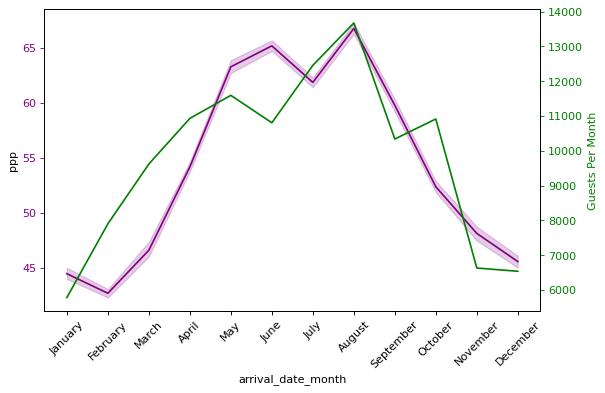

In [21]:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
d['arrival_date_month'] = pd.Categorical(d['arrival_date_month'], categories = ordered_months)


plt.xticks(rotation=45)
plt.tick_params(colors='purple',axis = 'y')
sns.lineplot(x='arrival_date_month', y = 'ppp', data = d,color = 'purple')
ax2 = plt.twinx()
ax2.set_ylabel('Guests Per Month',color = 'g')
d.groupby('arrival_date_month')['arrival_date_month'].count().plot(kind='line',color = 'g')
ax2.tick_params(colors='g')


plt.show()

In [22]:
# Fill nan's in the `agent` column with 536 (original range of codes for `agent` is 1 to 535)
d['agent'] = d['agent'].fillna(536)
# Fill nan's in the `company` column with 536 (original range of codes for `agent` is 6 to 543)
d['company'] = d['company'].fillna(544)

# Assume no children if `children` is nan
d['children'] = d['children'].fillna(0)
# Assume no babies if `babies` is nan
d['babies'] = d['babies'].fillna(0)

# Assume country is PRT if `country` is nan
#d['country'] = d['country'].fillna('PRT')

In [23]:
# Compare whether assigned and reserved rooms are the same
d['assigned_vs_reserved'] = (d['assigned_room_type'] == d['reserved_room_type'])

In [24]:
d2 = d.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','children','babies','reserved_room_type','assigned_room_type','agent','company',
        'required_car_parking_spaces','n_guests','weekday_diff','cancelation_ratio'], axis=1)

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## BASELINE MODEL

In [25]:
d3 = d.drop(['n_guests','weekday_diff','cancelation_ratio','family','total_stay','customers_lead','ppp','assigned_vs_reserved','agent','company'],axis=1)

list(d3.columns)

['is_canceled',
 'hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [26]:
y = d3.is_canceled
X = pd.get_dummies(d3.drop(["is_canceled"], axis=1), drop_first=True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV


scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


base_model = LogisticRegressionCV(cv = 5, scoring = 'roc_auc', max_iter=1000).fit(X_scaled, y_train)

In [29]:
base_model.score(X_scaled, y_train)

0.8629100414508613

## OPTIMIZED MODELS

In [30]:
list(d2.columns)

['is_canceled',
 'hotel',
 'lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'total_of_special_requests',
 'family',
 'total_stay',
 'customers_lead',
 'ppp',
 'assigned_vs_reserved']

In [31]:
perc_missing_data = pd.DataFrame([d2.isnull().sum(),d2.isnull().sum()*100.0/d2.shape[0]]).T
perc_missing_data.columns = ['No. of Missing Data', '% Missing Data']
perc_missing_data

,No. of Missing Data,% Missing Data
is_canceled,0.0,0.0
hotel,0.0,0.0
lead_time,0.0,0.0
arrival_date_week_number,0.0,0.0
stays_in_weekend_nights,0.0,0.0
stays_in_week_nights,0.0,0.0
adults,0.0,0.0
meal,0.0,0.0
market_segment,0.0,0.0
distribution_channel,0.0,0.0


In [32]:
y = d2.is_canceled
X = pd.get_dummies(d2.drop(["is_canceled"], axis=1), drop_first=True)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1)

In [34]:
pipeline = Pipeline([('DecisionTreeClassifier', DecisionTreeClassifier())])

params = {'DecisionTreeClassifier__max_depth': np.arange(10,20)}

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [35]:
print(model.best_estimator_)
print(model.best_score_)

Pipeline(steps=[('DecisionTreeClassifier',
                 DecisionTreeClassifier(max_depth=13))])
0.8806605222031175


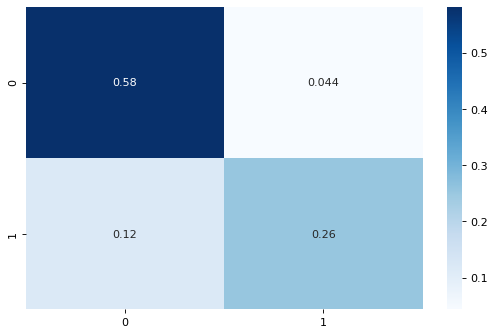

In [36]:
sns.heatmap(confusion_matrix(y_train, model.predict(X_train))/len(y_train), annot = True, cmap="Blues");

In [37]:
# Logistic Regression
pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                     ('LogisticRegression', LogisticRegression(multi_class='ovr', solver='liblinear', verbose=0))])

params = {'LogisticRegression__C': [200, 500, 1000, 2000, 5000], 
          'LogisticRegression__penalty': ['l1']} 
# Tried C = [0.01, 0.1, 1, 10, ..., 100000], and C = [200, 500, 1000, 2000, 5000]

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model_LR = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [38]:
print(model_LR.best_estimator_)
print(model_LR.best_score_)

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('LogisticRegression',
                 LogisticRegression(C=2000, multi_class='ovr', penalty='l1',
                                    solver='liblinear'))])
0.8507642373769613


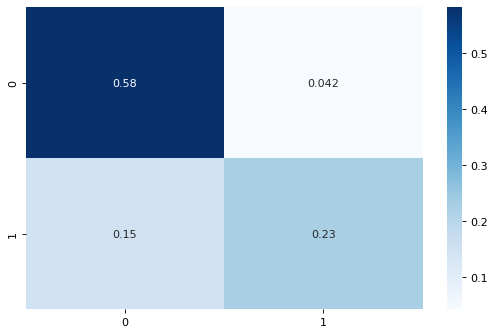

In [39]:
sns.heatmap(confusion_matrix(y_train, model_LR.predict(X_train))/len(y_train), annot = True, cmap="Blues");

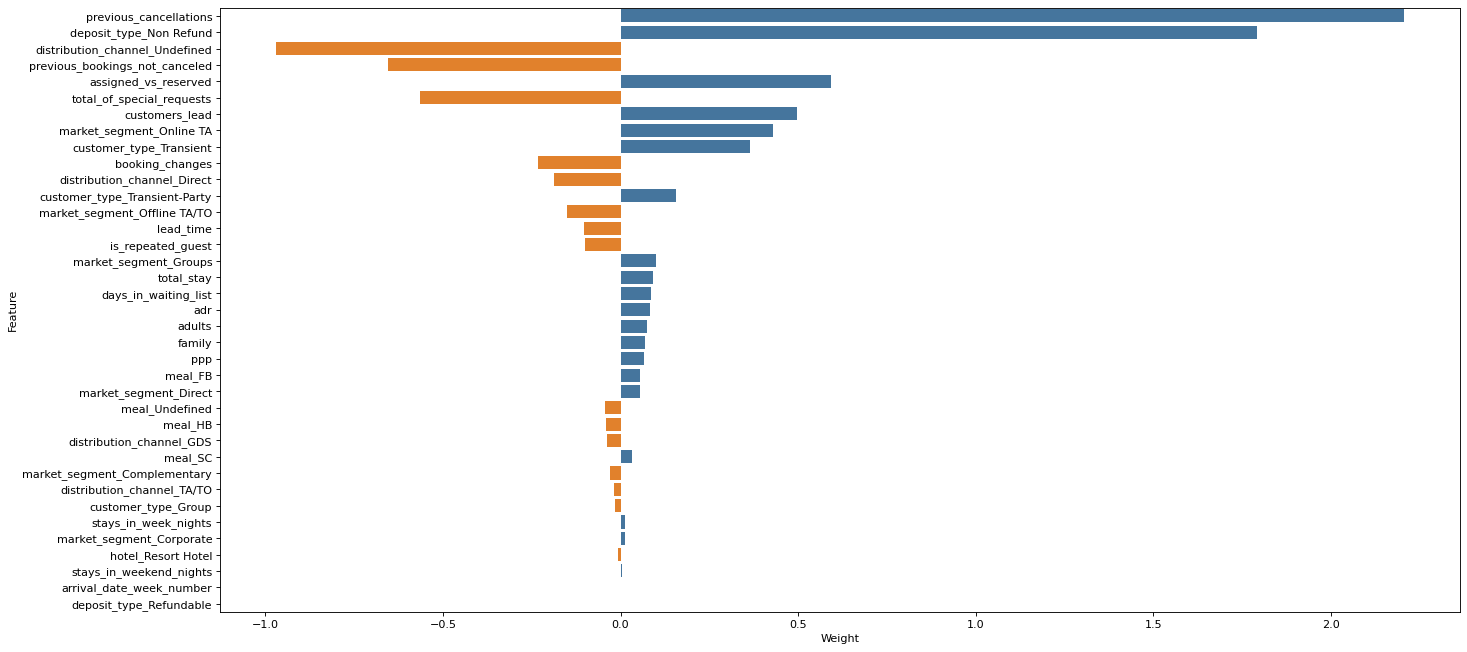

In [46]:
plt.figure(figsize=(20,10))

# Logistic regression weights
model_LR_weights = pd.DataFrame({'Feature': X.columns, 
                                 'Weight': model_LR.best_estimator_.named_steps['LogisticRegression'].coef_[0], 
                                 'abs_weight': abs(model_LR.best_estimator_.named_steps['LogisticRegression'].coef_[0])})

# Sort weights by absolute values
model_LR_weights = model_LR_weights.sort_values(by='abs_weight', ascending=False).drop(['abs_weight'], axis=1)

# Specify colors for positive and negative values
colors = ['#ff7f0e' if x < 0 else '#3776ab' for x in model_LR_weights.Weight]

sns.barplot(y = 'Feature', x = 'Weight', data = model_LR_weights, palette = colors)
plt.show();

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

Having explored numerous logistic models, decision trees and random forests, we decided a logistic model would best suit the task at hand. While the random forest has slightly superior performance (AUC = XXX), this gain outweighed by the much improved interpretability of the logistic model. The decision tree model was similarly too deep to interpret meaningfully or too unabalanced in its predictions, excessively minimizing false positives at the expense of false negatives. The logistic model on the other hand provides the best balance between performance and interpretability as well as false positive and false negative errors. 

Specifically, the logistic model achieves a cross-validated AUC of XXX which is comparable to Almeida, Antonio and Nunes' (2017a) results using the same data. Overall accuracy is XXX and precision is high as well at XXX. This performance translates well to unseen test data, achieving a respectable test-AUC of XXX. Bootstrapping was applied to add a 95% confidence interval on this estimate of the generalization error. Results indicate that the performance is stable with the 95%-CI being $\pm$ XXX. This shows that the model we developed is both high-performing and reliable.

We believe the hotel managers will be particularly interested in three components. What proportion of cancellations is detected, to what extent can these predictions be trusted and finally, which actions should the hotel take. Our model is able to detect most albeit not all cancellations (XXX%). Cancellations that are predicted can, however, be trusted as precision is very high (XXX%). This means that the hotel can confidently take mitigating actions: A low-risk low-impact strategy is to attempt to persuade customers which are predicted to cancel to stay. This can be done by offering discounts, upgrades or other special offers. This is low-risk because the investment is minor however also low-impact as many customers may be insensitive to price. Indeed, this is shown by our model as the rate of the booking and in particular the relative price compared to similar bookings is not a significant factor in cancellations. Particularly during periods of high demand, hotels should instead develop their overbooking strategy. This entails offering rooms of customers likely to cancel. Thereby, hotel can effectively prevent revenue loss due to empty rooms. This is however more risky as having insufficient capacity to serve all overbooked customers will result in high costs such as loss of customer loyalty. Therefore, we emphasise that high accuracy is important and allows for such a risky strategy to be taken confidently. 

Finally, the hotel may benefit from understanding what drives cancellations and which long-term strategic changes can be applied to prevent cancellations in future. Our model provides insight to this question as well. Specifically, customers' cancellation history is a the most significant predictor. Sensibly, customers who have cancelled bookings before are likely to do so again and those that have a history of not cancelling their bookings are likely to continue this trend. Hotels should therefore focus their promotions on loyal customers rather than trying to capture customers that have cancelled in the past. 

ADD TO THIS SECTION ONCE THE DATA IS IN.

In conclusion, we believe that our model is an effective tool to help hotels predict whether individual customers are likely to cancel. Targeted promotional activities can then be applied. Similarly, the hotel can better understand the number of total cancellations and develop a data-driven overbooking strategy to prevent empty rooms. Finally, long-term strategic changes may allow the hotel to prevent cancellations in future. Thus, we believe our model   

## 5. Convert Document

In [41]:
# Run the following to render to PDF
#!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
[NbConvertApp] Support files will be in proj2_files\
[NbConvertApp] Making directory .\proj2_files
[NbConvertApp] Making directory .\proj2_files
[NbConvertApp] Making directory .\proj2_files
[NbConvertApp] Making directory .\proj2_files
[NbConvertApp] Writing 75778 bytes to .\notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "C:\Users\Ellio\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\Ellio\anaconda3\lib\site-packages\jupyter_core\application.py", line 268, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\Ellio\anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Ellio\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "C:\Users\Ellio\anaconda3\lib\site-